This is supposed to be a "frozen" notebook, which has an lstm learning to swingup a cartpole from a single example

In [1]:
# Force keras to use the CPU becuase it's actually faster for this size network
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd

from numpy import cos, sin, pi
import matplotlib.pyplot as plt
import scipy.integrate as integrate

%matplotlib inline
import matplotlib.animation as animation

from IPython.display import HTML

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.constraints import max_norm

from cartpole_class import Cartpole

ImportError: cannot import name 'AbstractMethodError'

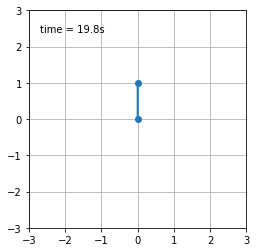

In [2]:
bot = Cartpole()

# time step
dt = 0.1
time = np.arange(0.0, 20, dt)

rad = np.pi / 180


num_trials = 1
num_states = 4
num_t = len(time)
y = np.zeros((num_t, num_states, num_trials))


for i in range(num_trials):
    # initial conditions
    theta = 0
    x = 0.0
    th_dot = 2*(i/num_trials) - 1  # an initial velocity, triggers the swing up control
    xdot = 0.0

    # initial state
    state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    u_hist = []
    y[:, :, i] = integrate.odeint(bot.derivs, state, time)


u = np.zeros((num_t, num_trials))
for i in range(num_trials):
    for t in range(num_t):
        u[t,i] = bot.control(y[t,:,i]) 

        
ani = bot.animate_cart(time, y[:,:,0])
HTML(ani.to_jshtml())

In [3]:
# Create our LSTM network

look_back = 1

with tf.variable_scope('pi/pol/'):
    model = Sequential()
    #model.add(SimpleRNN(12, input_shape=(4,look_back)))
    model.add(LSTM(12, input_shape =(4,look_back)))
    model.add(Dense(1))

    #model.add(Dense(2))
    

model.compile(loss='mean_squared_error', optimizer='adam')

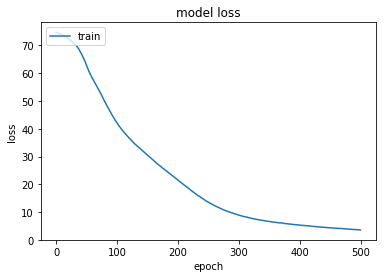

In [4]:
history = model.fit(y, u, epochs=500, verbose=0)
%matplotlib inline
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [5]:
# This is a closure that returns our NN controller
def make_controller(model):
    def nn_controller(q):
        if (q[0] < 140 * rad) or (q[0] > 220 * rad):
            return model.predict(q.reshape((1,4,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller

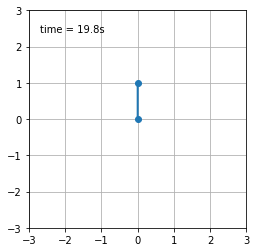

In [6]:
control = make_controller(model)

# initial conditions
theta = 0
x = 0
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
t_index = np.arange(0.0, 20, dt)


# initial state
state = np.array([theta, x, th_dot, xdot])

# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..
y_test = integrate.odeint(bot.derivs, state, t_index)
u_test = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_test[t] = control(y[t]) 

        
data = np.concatenate((y_test, u_test),axis=1)
names = ['theta','x','thetadot','xdot','u']
yf = pd.DataFrame(data = data, index = t_index, columns = names)


ani = bot.animate_cart(t_index, y_test)
HTML(ani.to_jshtml())

In [ ]:
# messing with multiindexing 
# TODO probably move this to the misc folder, preferably as a more complete example than this one.

names = [
    ('state', 'theta'),
    ('state', 'x'),
    ('state', 'thetadot'),
    ('state', 'xdot'),
    ('control' ,'u')
]

yf = pd.DataFrame(data = data, index = t_index, columns=pd.MultiIndex.from_tuples(names))
